In [ ]:
mkdir Particle_images

In [ ]:
cd Particle_images

/content/Particle_images


In [ ]:
mkdir data

In [ ]:
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2020-10-30 19:30:10--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 188.184.97.72, 137.138.120.151, 128.142.32.26, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|188.184.97.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  18.9MB/s    in 5.5s    

Last-modified header invalid -- time-stamp ignored.
2020-10-30 19:30:18 (15.2 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2020-10-30 19:30:18--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.32.26, 128.142.32.38, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391

Creating DataLoaders for PyTorch

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import h5py
import numpy as np
 
def load_data(decays):
    dsets = [h5py.File('%s'%(decay)) for decay in decays]
    X = np.concatenate([dset['/X'] for dset in dsets])
    y = np.concatenate([dset['/y'] for dset in dsets])
    assert len(X) == len(y)
    return X, y
 
paths = [r'/content/Particle_images/data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', r'/content/Particle_images/data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5']
X, y = load_data(paths)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if __name__ == '__main__':


In [ ]:
## Custom Dataset

class ImgDataset(Dataset):
    def __init__(self, images, labels):
        self.labels = labels
        self.images = images

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        images = self.images[idx, :, :, :]
        labels = self.labels[idx]
        sample = [torch.from_numpy(images).reshape(2, 32, 32), torch.tensor(labels)]
        return sample

In [ ]:
dataset = ImgDataset(X, y)
dataset[0][0].shape

torch.Size([2, 32, 32])

In [ ]:
trainset, testset = torch.utils.data.random_split(dataset, [400000, 23300])
testset, valset = torch.utils.data.random_split(testset, [11650, 11650])

In [ ]:
## Creating Dataloaders 

train_dl = DataLoader(trainset, batch_size= 1024, shuffle= True, num_workers= 4, pin_memory=True)
test_dl = DataLoader(testset, batch_size= 1024, shuffle= True, num_workers= 4, pin_memory=True)
val_dl = DataLoader(valset, batch_size= 1024, shuffle= True, num_workers= 4, pin_memory=True)

In [ ]:
## Helper functions to help use cuda for training

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
## Wrapping the DataLoader to add GPU support

train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F

# Model:

In [ ]:
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(2, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            # nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            # nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5),

            nn.Flatten(), 
            nn.Linear(128, 128),
            nn.Dropout(0.4),
            nn.LeakyReLU(),
            nn.Linear(128, 2),
        )
        
    def forward(self, xb):
        return self.network(xb)

model1 = LeNet()
model1 = model1.to(device)
model1

LeNet(
  (network): Sequential(
    (0): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): Flatten()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [ ]:
from torchsummary import summary

summary(model1, (2,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           1,632
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         LeakyReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 10, 10]          51,264
       BatchNorm2d-6           [-1, 64, 10, 10]             128
         LeakyReLU-7           [-1, 64, 10, 10]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
            Conv2d-9            [-1, 128, 1, 1]         204,928
          Flatten-10                  [-1, 128]               0
           Linear-11                  [-1, 128]          16,512
          Dropout-12                  [-1, 128]               0
        LeakyReLU-13                  [-1, 128]               0
           Linear-14                   

# Evalutaion functions

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

def evaluate(model, val_dl):
    model.eval()
    val_acc, val_loss = [], []
    for batch in val_dl:
        img, labels = batch
        # img = img.to(device)
        # labels = labels.to(device)
        with torch.no_grad():
            out = model(img)
            loss = F.cross_entropy(out, labels.long())
            acc = accuracy(out, labels)
            val_loss.append(loss.detach())
            val_acc.append(acc)
    return sum(val_loss)/len(val_loss), sum(val_acc)/len(val_acc)



def fit(model, epochs, train_dl, validation_dl, lr=1e-3):

    optimizer= torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
    
    print("Start of training")
    train_acc, train_loss, val_acc, val_loss= [], [], [], []

    for epoch in range(epochs):
        
        epoch_loss, epoch_acc = [], []

        for batch in train_dl:
            model.train()
            img, labels = batch
            # img = img.to(device)
            # labels = labels.to(device)
            out = model(img)
            loss = F.cross_entropy(out, labels.long())
            acc = accuracy(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss.append(loss)
            epoch_acc.append(acc)
            
        
        train_loss.append(sum(epoch_loss)/len(epoch_loss))
        train_acc.append(sum(epoch_acc)/len(epoch_acc))

        vald_loss, vald_acc  = evaluate(model, val_dl)

        val_acc.append(vald_acc)
        val_loss.append(vald_loss)

        scheduler.step()

        print(f'Epoch: {epoch+1}/{epochs} -- Train Loss: {sum(epoch_loss)/len(epoch_loss)} -- Train Acc: {sum(epoch_acc)/len(epoch_acc)} -- Val Loss: {vald_loss} -- Val Acc: {vald_acc}') 
    
    return {"train_loss": train_loss , "train_acc" : train_acc, "val_loss" : val_loss, "val_acc": val_acc}

# Training phase

In [ ]:
# Before training
l, a = evaluate(model1, train_dl)
print(f"Training loss = {l}, Training accuracy = {a}")
print("========================================")
l, a = evaluate(model1, val_dl)
print(f"Validation loss = {l}, Validation accuracy = {a}")
print("========================================")
l, a = evaluate(model1, test_dl)
print(f"Test loss = {l}, Test accuracy = {a}")

Training loss = 0.6941447854042053, Training accuracy = 0.5004165768623352
Validation loss = 0.6940932273864746, Validation accuracy = 0.5009200572967529
Test loss = 0.6951442956924438, Test accuracy = 0.4895934760570526


In [ ]:
# model1 = torch.load("/content/entire_model.pth")

In [ ]:
# model1.load_state_dict(torch.load("/content/stdict.pth"))
# model1.eval()

In [ ]:
# Training cell, do not run if using pre-trained model

import datetime

start = datetime.datetime.now()

history = fit(model1, 50, train_dl, val_dl);

print(datetime.datetime.now()-start)

Start of training
Epoch: 1/50 -- Train Loss: 0.6724432110786438 -- Train Acc: 0.584141731262207 -- Val Loss: 0.6596486568450928 -- Val Acc: 0.5995191335678101
Epoch: 2/50 -- Train Loss: 0.6611829996109009 -- Train Acc: 0.6030450463294983 -- Val Loss: 0.6559586524963379 -- Val Acc: 0.6087480187416077
Epoch: 3/50 -- Train Loss: 0.6576270461082458 -- Train Acc: 0.6086412072181702 -- Val Loss: 0.6579647660255432 -- Val Acc: 0.6089739799499512
Epoch: 4/50 -- Train Loss: 0.6547133326530457 -- Train Acc: 0.6127777695655823 -- Val Loss: 0.6510553956031799 -- Val Acc: 0.6166983842849731
Epoch: 5/50 -- Train Loss: 0.6502859592437744 -- Train Acc: 0.6204038858413696 -- Val Loss: 0.6475688219070435 -- Val Acc: 0.6242915987968445
Epoch: 6/50 -- Train Loss: 0.6463536024093628 -- Train Acc: 0.6269891262054443 -- Val Loss: 0.6452093124389648 -- Val Acc: 0.630179226398468
Epoch: 7/50 -- Train Loss: 0.6415596008300781 -- Train Acc: 0.6345323324203491 -- Val Loss: 0.6384236216545105 -- Val Acc: 0.6353378

In [ ]:
# After training
model1.eval()
l, a = evaluate(model1, train_dl)
print(f"Training loss = {l}, Training accuracy = {a}")
print("========================================")
l, a = evaluate(model1, val_dl)
print(f"Validation loss = {l}, Validation accuracy = {a}")
print("========================================")
l, a = evaluate(model1, test_dl)
print(f"Test loss = {l}, Test accuracy = {a}")

Training loss = 0.5362863540649414, Training accuracy = 0.735236644744873
Validation loss = 0.6067431569099426, Validation accuracy = 0.6898355484008789
Test loss = 0.6198243498802185, Test accuracy = 0.6759229302406311


# Evaluation Phase

In [ ]:
from sklearn.metrics import roc_curve, auc
model1.eval()
# Compute ROC curve and ROC area on validation set

for batch in val_dl:
    input, label = batch
    break

target = label.cpu().numpy()

curve_out = model1(input)
_, pred = torch.max(curve_out, dim=1)

y_score = pred.cpu().numpy()

fpr, tpr, _ = roc_curve(target, y_score)
roc_auc= auc(fpr, tpr)

print(f'Val roc_auc = {roc_auc}')

# Compute ROC curve and ROC area on test set

for batch in test_dl:
    input, label = batch
    break
    
target = label.cpu().numpy()

curve_out = model1(input)
_, pred = torch.max(curve_out, dim=1)

y_score = pred.cpu().numpy()

fpr, tpr, _ = roc_curve(target, y_score)
roc_auc= auc(fpr, tpr)
print(f'Test roc_auc = {roc_auc}')

Val roc_auc = 0.6775800168054389
Test roc_auc = 0.664751330624392


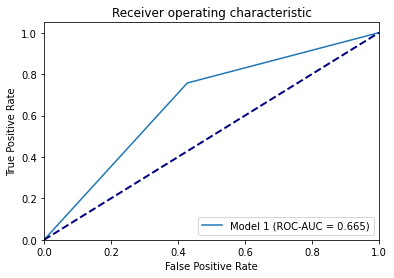

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
lw = 2
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# plt.plot([0, 1], [0, 1], 'k--')
# #plt.legend(loc=2, prop={'size': 15})
# plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

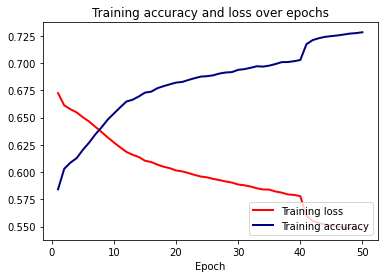

In [ ]:
n_epochs = len(history["train_loss"])

plt.figure()
plt.plot(range(1,n_epochs+1), history["train_loss"], label="Training loss", color = "red", lw=2)
plt.plot(range(1,n_epochs+1), history["train_acc"], label="Training accuracy", color = "navy", lw=2)
plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Training accuracy and loss over epochs')
plt.legend(loc="lower right")
plt.show()

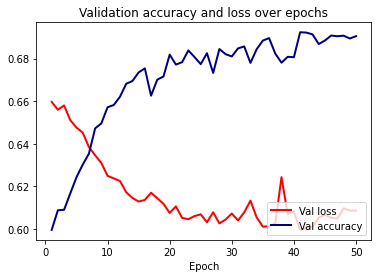

In [ ]:
plt.figure()
plt.plot(range(1,n_epochs+1), history["val_loss"], label="Val loss", color = "red", lw=2)
plt.plot(range(1,n_epochs+1), history["val_acc"], label="Val accuracy", color = "navy", lw=2)
plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Validation accuracy and loss over epochs')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model1.eval()
torch.save(model1.state_dict(), "/content/stdict.pth")

In [ ]:
model1.eval()
torch.save(model1, "/content/entire_model.pth")